In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import pyvista as pv
from myusefultools.parser import getVTKList
from ipywidgets.widgets import RadioButtons

## Pyvista global settings
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')
pv.global_theme.transparent_background = False
pv.global_theme.show_scalar_bar = True
pv.start_xvfb()

In [2]:
pickDataset = RadioButtons(options=['LES', 'RAS'], value='LES', description='Dataset?')
display(pickDataset)


RadioButtons(description='Dataset?', options=('LES', 'RAS'), value='LES')

In [3]:
## Import last time-step from LES model
if pickDataset.value == 'LES':
    folderName = r'/home/edsaa/nuModel/tempResults_review/noRelax_dp9.LES/VTK/'  #LES
elif pickDataset.value == 'RAS':
    folderName = r'/home/edsaa/nuModel/tempResults_review/noRelax_dp9.RANS/VTK/'    #RANS

fileName = getVTKList(folderName)[-1]
filePath = os.path.join(folderName,fileName)
dataset = pv.read(filePath)

## Get a 2D slice and work on that 
clipPoint  = (0,-0.05,0)  ## Clip to not show the deeper section
slicePoint = (0,0,SLICEZ:=0.15)   ## Ignore the 3D and just plot a 2D slice
slice = dataset.clip(normal='y',origin=clipPoint,invert=False).slice(normal='z',origin=slicePoint)

In [4]:
## Function for all the plotting verbose
def plotField(mesh, field:str): 
    kw_add_mesh = dict(scalars=field,n_colors=128,cmap="bone_r",lighting=False)
    plotter = pv.Plotter(off_screen=False)
    plotter.parallel_projection = True
    plotter.add_mesh(mesh,**kw_add_mesh)
    plotter.add_axes()
    plotter.camera_position = 'xy'
    plotter.camera.zoom(2.0)
    plotter.show(window_size=[600,350],return_img=True)

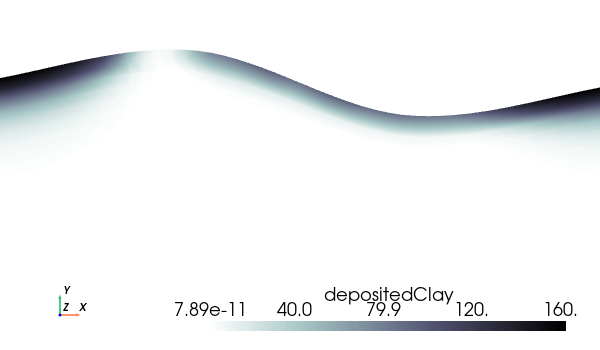

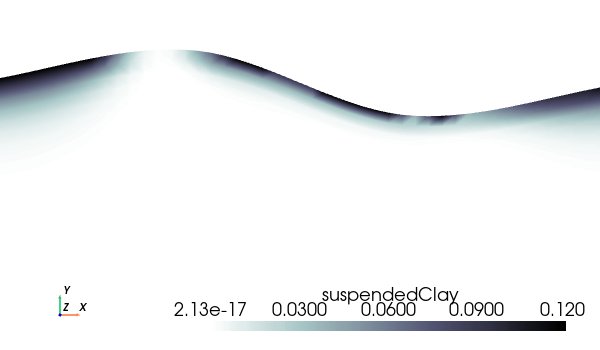

In [5]:
for field in ["depositedClay","suspendedClay"]: plotField(slice,field)

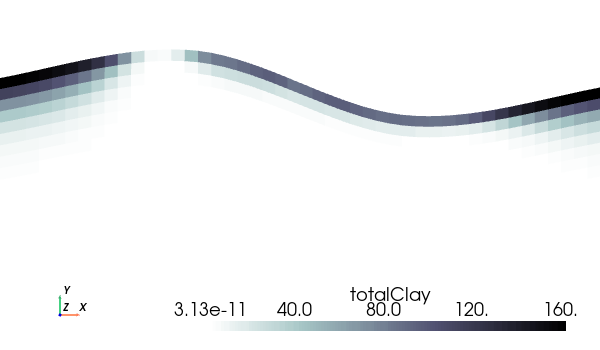

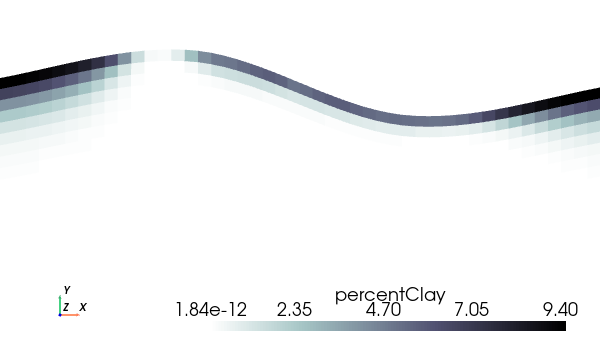

In [6]:
## Convert to percent clay to keep units from Fox et al. 
DENSITY_OF_SAND = 2650.
CLEAN_POROSITY  = 0.358

slice['totalClay'] = slice['depositedClay'] + (slice['suspendedClay']*slice['n'])
slice['percentClay'] = 100. * slice['totalClay']/(DENSITY_OF_SAND * (1.0 - CLEAN_POROSITY)) 

for field in ["totalClay","percentClay"]: plotField(slice,field)

In [7]:
## Import experimental results from Fox et al. 2018
with open('ExperimentalData.pkl','rb') as f:
    ExperimentalData = pickle.load(f)

In [8]:
# Create planes at the core locations
z = SLICEZ - 0.01
cores_planes = [[pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.10,0.13]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.14,0.17]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.18,0.21]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.22,0.25]]]

In [9]:
## Plot lines of cores
cores_id = ['Core A','Core B','Core C','Core D']
core_color = ['r','g','b','orange']

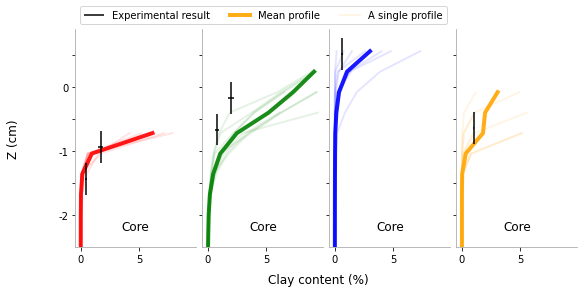

In [10]:
## Create a bunch of lines at each core location to probe
probes_resolutionx = 8
cores_x = [np.linspace(0.10,0.13,probes_resolutionx),
           np.concatenate(
            (np.linspace(0.14,0.15,int(probes_resolutionx/2)),
             np.linspace(0.01,0.02,int(probes_resolutionx/2)))),
           np.linspace(0.03,0.06,probes_resolutionx),
           np.linspace(0.07,0.10,probes_resolutionx)]

fig,axs = plt.subplots(1,4,sharey=True,sharex=True,
            gridspec_kw={'wspace':0.05},figsize=[9,4])

## For each line of each core, run a sample_over_line()
for i,core in enumerate(cores_x):
    pC_accum,y_accum = [],[]
    for x in core:
        line_bottom, line_top = (x,-0.10,SLICEZ), (x, 0.06,SLICEZ)
        samples = slice.sample_over_line(line_top,line_bottom,resolution=50)
        pC = np.ma.masked_where(samples['vtkValidPointMask']<1.0,samples['percentClay'])
        y  = np.ma.masked_where(samples['vtkValidPointMask']<1.0,samples.points[:,1])
        pC_accum.append(pC)
        y_accum.append(y)
        littleLine = axs[i].plot(pC,y,color=core_color[i],alpha=0.1,lw=2,zorder=1)

    # Get representative value for core    
    pC_accum = np.ma.stack(pC_accum,axis=0)
    meanPc = pC_accum.mean(axis=0)
    y_accum = np.ma.stack(y_accum,axis=0)
    meanY = y_accum.mean(axis=0)
    bigLine = axs[i].plot(meanPc,meanY,color=core_color[i],alpha=0.9,lw=4,ls='-',zorder=3)
    
    #stdPc = pC_accum.std(axis=0)
    #axs[i].plot(meanPc+stdPc,meanY,color=core_color[i],alpha=0.9,lw=2,ls='-')
    #axs[i].plot(meanPc-stdPc,meanY,color=core_color[i],alpha=0.9,lw=2,ls='-')

for ax in axs: 
    ax.set_title("Core",y=0.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('darkgray')
    ax.spines['bottom'].set_color('darkgray')
    
axs[0].set_ylim([-0.025,0.009])
#axs[0].set_xlim([-0.4,5.0])
axs[0].set_yticks([0.005,0,-0.005,-0.01,-0.015,-0.02])
axs[0].set_yticklabels(['','0','','-1','','-2'])

fig.supxlabel('Clay content (%)',y=-0.01)
fig.supylabel('Z (cm)')

## Measurements
experiment = ExperimentalData['Neutral']
ycores = ExperimentalData['Y']
ccores = ExperimentalData['Neutral']['C']
scores = ExperimentalData['Neutral']['std']

for y,cv,sv,ax in zip(ycores,ccores,scores,axs):
    dy = 0.5E-2
    y1 = y
    y2 = y - dy
    for c,s in zip(cv,sv):
        linecollection = ax.vlines(c,y2,y1,colors='k',zorder=4)
        ym = (y1+y2)/2
        ax.hlines(ym,c-s,c+s,colors='k',zorder=4)
        y1 -= dy
        y2 -= dy

axs[0].legend([linecollection]+bigLine+littleLine,
              ['Experimental result','Mean profile','A single profile'],
              loc='lower left',ncol=3,bbox_to_anchor=(0.0,1))
#plt.savefig("ProfilingLES.svg")
plt.show()